Copyright (c) 2019 [Sebastian Raschka](sebastianraschka.com)

https://github.com/rasbt/python-machine-learning-book-3rd-edition

[MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Python. Uczenie maszynowe - kod źródłowy

# Chapter 9 - Embedding a Machine Learning Model into a Web Application

Zwróć uwagę, że rozszerzenie zawierające nieobowiązkowy znak wodny stanowi niewielki plugin notatnika IPython / Jupyter, który zaprojektowałem w celu powielania kodu źródłowego. Wystarczy pominąć poniższe wiersze kodu:

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka" -u -d -v -p numpy,pandas,pyprind,matplotlib,nltk,sklearn,flask

Sebastian Raschka 
last updated: 2019-08-21 

CPython 3.7.1
IPython 7.7.0

numpy 1.16.4
pandas 0.24.2
pyprind 2.11.2
matplotlib 3.1.0
nltk not installed
sklearn 0.21.1
flask 1.1.1


*Korzystanie z rozszerzenia `watermark` nie jest obowiązkowe. Możesz je zainstalować za pomocą polecenia:*  

    conda install watermark -c conda-forge  

lub  

    pip install watermark   

*Więcej informacji znajdziesz pod adresem: https://github.com/rasbt/watermark.*

In [1]:
from IPython.display import Image

<br>
<br>

### Spis treści

- [Powtórka z rozdziału 8.: Uczenie modelu w celu klasyfikowania recenzji filmowych](#Powtórka-z-rozdziału-8.:-Uczenie-modelu-w-celu-klasyfikowania-recenzji-filmowych)
- [Serializacja wyuczonych estymatorów biblioteki scikit-learn](#Serializacja-wyuczonych-estymatorów-biblioteki-scikit-learn)
- [Konfigurowanie bazy danych SQLite](#Konfigurowanie-bazy-danych-SQLite)
- [Tworzenie aplikacji sieciowej za pomocą środowiska Flask](#Tworzenie-aplikacji-sieciowej-za-pomocą-środowiska-Flask)
- [Nasza pierwsza aplikacja sieciowa](#Nasza-pierwsza-aplikacja-sieciowa)
  - [Sprawdzanie i wyświetlanie formularza](#Sprawdzanie-i-wyświetlanie-formularza)
  - [Przekształcanie klasyfikatora recenzji w aplikację sieciową](#Przekształcanie-klasyfikatora-recenzji-w-aplikację-sieciową)
- [Umieszczanie aplikacji sieciowej na publicznym serwerze](#Umieszczanie-aplikacji-sieciowej-na-publicznym-serwerze)
  - [Aktualizowanie klasyfikatora recenzji filmowych](#Aktualizowanie-klasyfikatora-recenzji-filmowych)
- [Podsumowanie](#Podsumowanie)

Kod aplikacji napisanych w środowisku Flask znajduje się w następujących katalogach:
    
- `flask_pierwsza_aplikacja_1/`: prosta aplikacja sieciowa napisana we Flasku,
- `flask_pierwsza_aplikacja_2/`: aplikacja `flask_pierwsza_aplikacja_1` z dodanym sprawdzaniem i wyświetlaniem formularza,
- `klasyfikator_filmowy/`: klasyfikator recenzji zagnieżdżony w aplikacji sieciowej,
- `zaktualizowany_klasyfikator_filmowy/`: to samo, co `klasyfikator_filmowy` lecz z dodaną funkcją aktualizowania bazy danych w momencie uruchomienia.

Aby uruchomić lokalnie aplikacje sieciowe, przejdź za pomocą polecenia `cd` do katalogu zawierającego powyższe aplikacje i uruchom główny skrypt, np.:

    cd ./flask_pierwsza_aplikacja_1
    python3 app.py

Teraz w terminalu powinien pojawić się następujący tekst:

     * Running on http://127.0.0.1:5000/
     * Restarting with reloader

Otwórz następnie przeglądarkę i wpisz adres wyświetlony w terminalu (najczęściej http://127.0.0.1:5000/) aby przejrzeć zawartość aplikacji.

**Odnośnik do działającego przykładu (w języku angielskim) utworzonego przy użyciu informacji zawartych w rozdziale: http://raschkas.pythonanywhere.com/.**.

<br>
<br>

# Powtórka z rozdziału 8.: Uczenie modelu w celu klasyfikowania recenzji filmowych

W tym podrozdziale przypominam model regresji logistyczny, który trenowaliśmy na końcu rozdziału 7. Uruchom poniższe bloki kodu po to, aby wyuczyć model przeznaczony do serializacji:

**Uwaga**

Poniższy kod bazuje na zestawie danych `movie_data.csv` utworzonym w rozdziale 8.

In [3]:
import gzip


with gzip.open('movie_data.csv.gz') as f_in, open('movie_data.csv', 'wb') as f_out:
    f_out.writelines(f_in)

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sebastian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop = stopwords.words('english')
porter = PorterStemmer()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv) # pomija nagłówek
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

In [6]:
next(stream_docs(path='movie_data.csv'))

('"In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />""Murder in Greenwich"" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich f

In [7]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [8]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**21,
                         preprocessor=None, 
                         tokenizer=tokenizer)

clf = SGDClassifier(loss='log', random_state=1, max_iter=1)
doc_stream = stream_docs(path='movie_data.csv')

In [9]:
import pyprind
pbar = pyprind.ProgBar(45)

classes = np.array([0, 1])
for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:20


In [10]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)
print('Dokładność: %.3f' % clf.score(X_test, y_test))

Accuracy: 0.868


In [11]:
clf = clf.partial_fit(X_test, y_test)

### Uwaga

Podrozdział dotyczący serializacji może być nieco zawiły, dlatego umieściłem tu prostsze skrypty testowe (katalog `skrypty-testowe-pickle/`) sprawdzające, czy Twoje środowisko pracy jest prawidłowo skonfigurowane. W zasadzie mamy tu do czynienia z uproszczoną wersją przykładów opisanych w rozdziale 8., a także z bardzo małym wycinkiem zestawu danych IMdB.

Uruchomienie skryptu

    python pickle-dump-test.py

spowoduje wyuczenie niewielkiego modelu klasyfikacji z pliku `filmy_dane_niewielki.csv` i utworzenie dwóch plików: 

    stopwords.pkl
    classifier.pkl

Jeśli teraz uruchomisz skrypt

    python pickle-load-test.py

powinieneś otrzymać w wyniku dwa następujące wiersze:

    Prognoza: pozytywna
    Prawdopodobieństwo: 85.71%

In [12]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [13]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**21,
                         preprocessor=None, 
                         tokenizer=tokenizer)

clf = SGDClassifier(loss='log', random_state=1, max_iter=1)
doc_stream = stream_docs(path='movie_data.csv')

In [14]:
import pyprind
pbar = pyprind.ProgBar(45)


classes = np.array([0, 1])
for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:20


In [15]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)
print('Dokładność: %.3f' % clf.score(X_test, y_test))

Accuracy: 0.868


In [16]:
clf = clf.partial_fit(X_test, y_test)

<br>
<br>

# Serializacja wyuczonych estymatorów biblioteki scikit-learn

Po wytrenowaniu powyższego modelu regresji logistycznej zapisujemy klasyfikator wraz z pomijanymi wyrazami, algorytmem Portera oraz klasą `HashingVectorizer` w postaci serializowanych obiektów na dysku lokalnym, dzięki czemu będziemy mogli później korzystać w aplikacji sieciowej z wyuczonego modelu.

In [17]:
import pickle
import os

dest = os.path.join('klasyfikator_filmowy', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)   
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)

Teraz zapisujemy klasę `HashingVectorizer` w osobnym pliku, co pozwala nam na jej późniejsze importowanie.

In [18]:
%%writefile movieclassifier/vectorizer.py
from sklearn.feature_extraction.text import HashingVectorizer
import re
import os
import pickle

cur_dir = os.path.dirname(__file__)
stop = pickle.load(open(
                os.path.join(cur_dir, 
                'pkl_objects', 
                'stopwords.pkl'), 'rb'))

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) \
                   + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         tokenizer=tokenizer)

Overwriting movieclassifier/vectorizer.py


Po uruchomieniu powyższych komórek możemy ponownie uruchomić jądro aplikacji Jupyter Notebook, aby sprawdzić, czy serializacja przebiegła pomyślnie.

Najpierw zmieniamy bieżący katalog Pythona na `klasyfikator_filmowy`:

In [19]:
import os
os.chdir('klasyfikator_filmowy')

In [20]:
import pickle
import re
import os
from vectorizer import vect

clf = pickle.load(open(os.path.join('pkl_objects', 'classifier.pkl'), 'rb'))

In [21]:
import numpy as np
label = {0:'Negatywna', 1:'Pozytywna'}

example = ["I love this movie. It's amazing."]
X = vect.transform(example)
print('Prognoza: %s\nPrawdopodobieństwo: %.2f%%' %\
      (label[clf.predict(X)[0]], 
       np.max(clf.predict_proba(X))*100))

Prediction: positive
Probability: 95.55%


<br>
<br>

# Konfigurowanie bazy danych SQLite

Zanim uruchomisz poniższy kod upewnij się, że utworzyłeś katalog `klasyfikator_filmowy`.

Sprawdź, czy znajdujemy się ciągle w podkatalogu "klasyfikator_filmowy":

In [22]:
os.getcwd()

'/Users/sebastian/Desktop/ch09/movieclassifier'

In [23]:
import sqlite3
import os

conn = sqlite3.connect('reviews.sqlite')
c = conn.cursor()

c.execute('DROP TABLE IF EXISTS review_db')
c.execute('CREATE TABLE Recenzja_db (Recenzja TEXT, Sentyment INTEGER, Data TEXT)')

example1 = 'I love this movie'
c.execute("INSERT INTO Recenzja_db (Recenzja, Sentyment, Data) VALUES (?, ?, DATETIME('now'))", (example1, 1))

example2 = 'I disliked this movie'
c.execute("INSERT INTO Recenzja_db (Recenzja, Sentyment, Data) VALUES (?, ?, DATETIME('now'))", (example2, 0))

conn.commit()
conn.close()

In [24]:
conn = sqlite3.connect('reviews.sqlite')
c = conn.cursor()

c.execute("SELECT * FROM Recenzja_db WHERE Data BETWEEN '2017-01-01 10:10:10' AND DATETIME('now')")
results = c.fetchall()

conn.close()

In [25]:
print(results)

[('I love this movie', 1, '2019-06-15 17:53:46'), ('I disliked this movie', 0, '2019-06-15 17:53:46')]


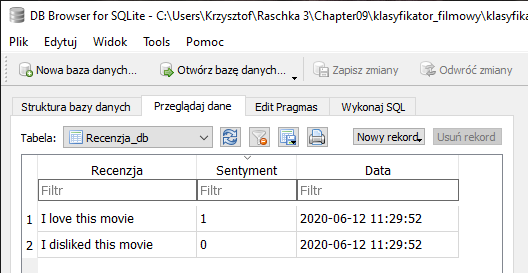

In [3]:
Image(filename='rysunki/09_01.png', width=700) 

<br>

# Tworzenie aplikacji sieciowej za pomocą środowiska Flask

...

## Nasza pierwsza aplikacja sieciowa

...

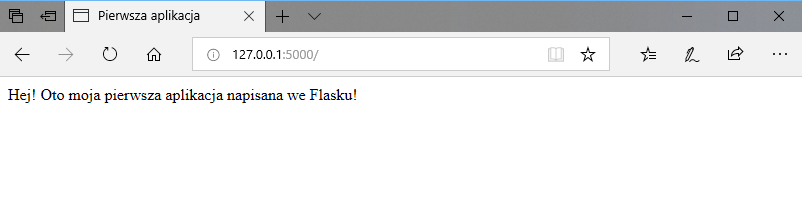

In [4]:
Image(filename='rysunki/09_09.png', width=700) 

## Form validation and rendering

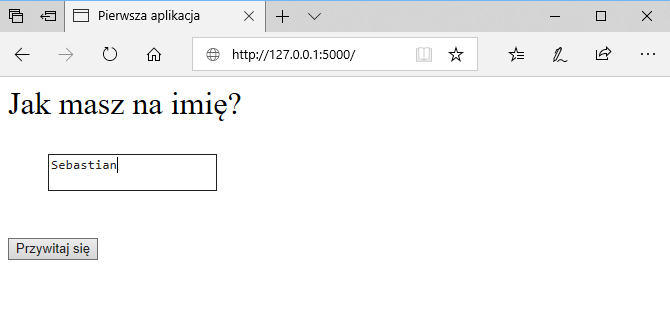

In [5]:
Image(filename='rysunki/09_02.png', width=400) 

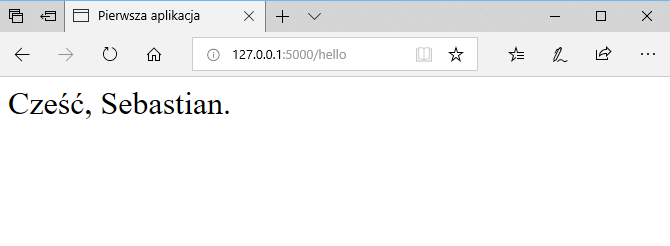

In [6]:
Image(filename='rysunki/09_03.png', width=400) 

<br>
<br>

## Rysunki podsumowujące

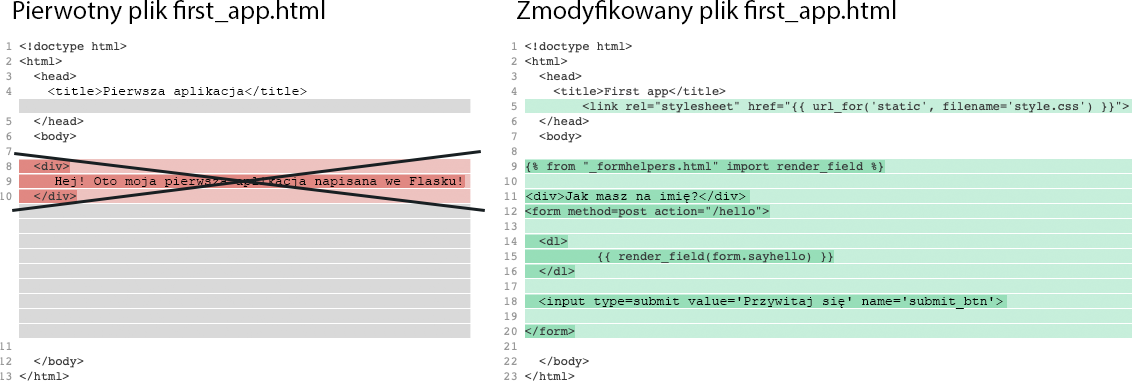

In [7]:
Image(filename='./rysunki/09_11.png', width=800) 

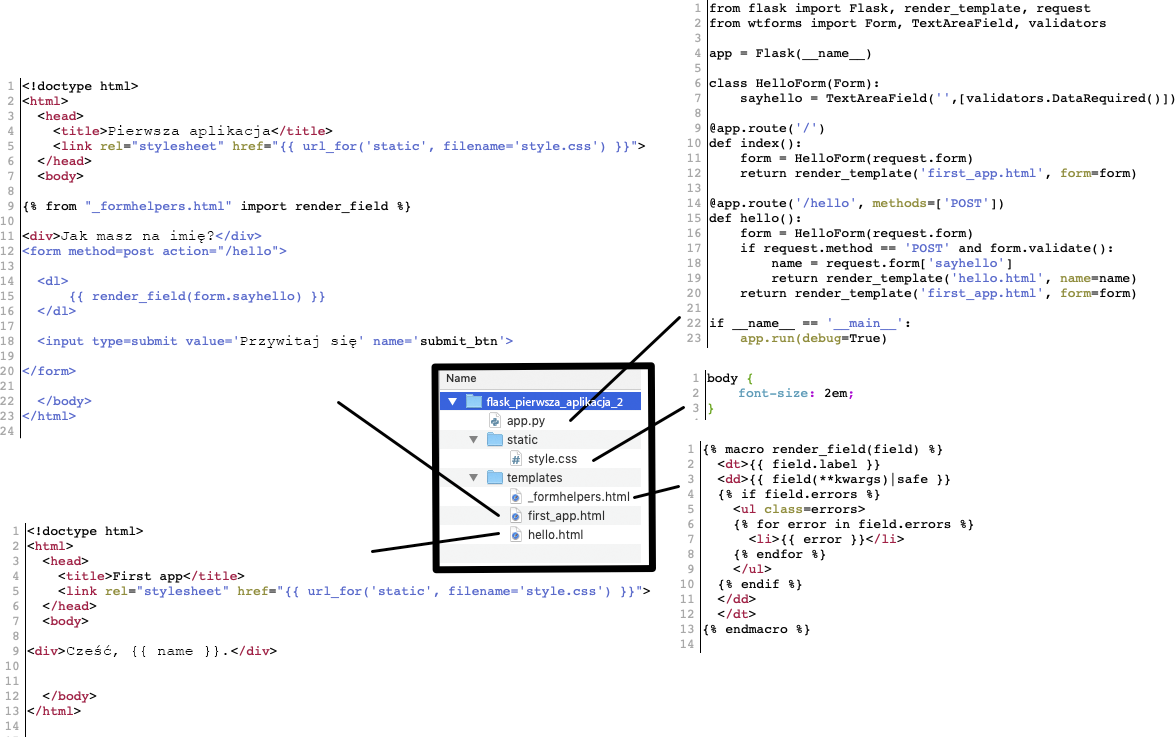

In [8]:
Image(filename='./rysunki/09_12.png', width=800) 

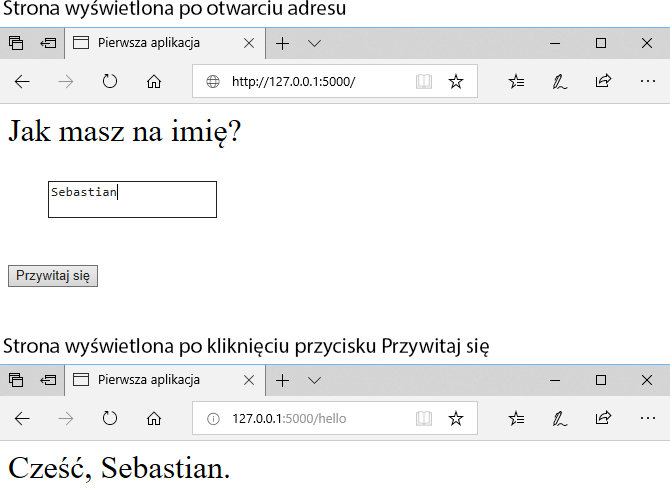

In [9]:
Image(filename='./rysunki/09_13.png', width=400) 

# Przekształcanie klasyfikatora recenzji w aplikację sieciową

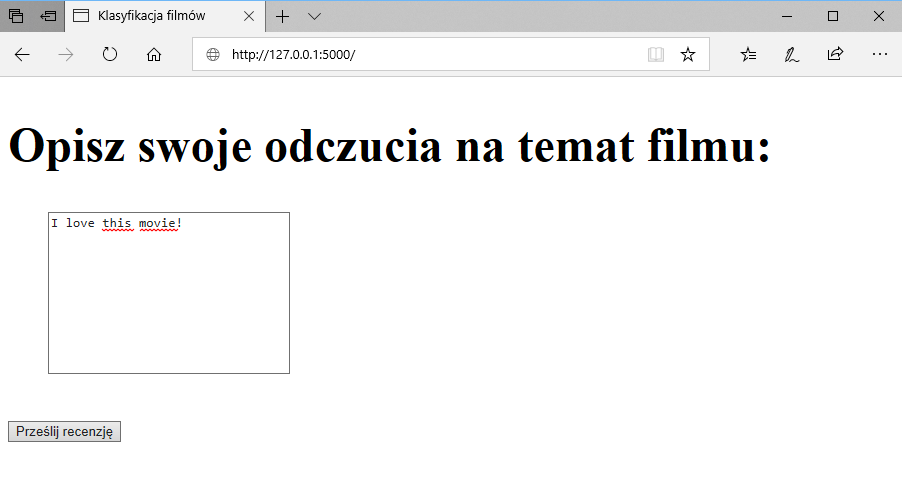

In [11]:
Image(filename='./rysunki/09_04.png', width=400) 

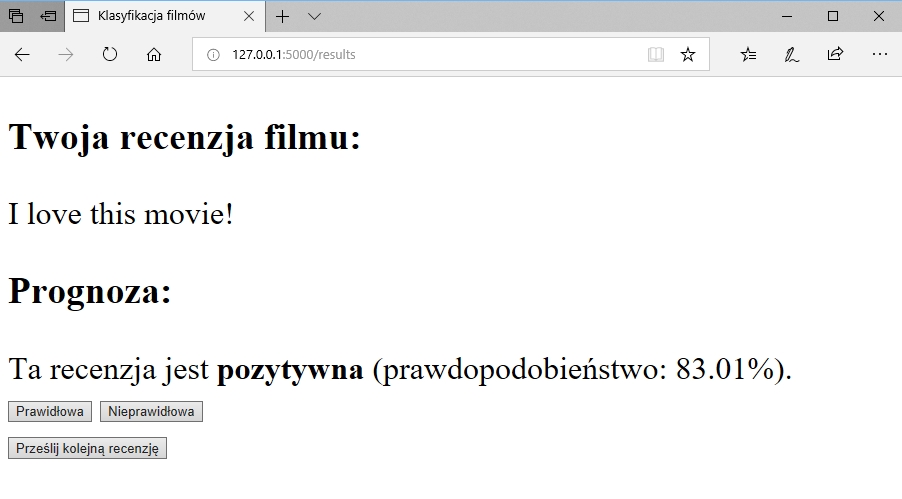

In [12]:
Image(filename='./rysunki/09_05.png', width=400) 

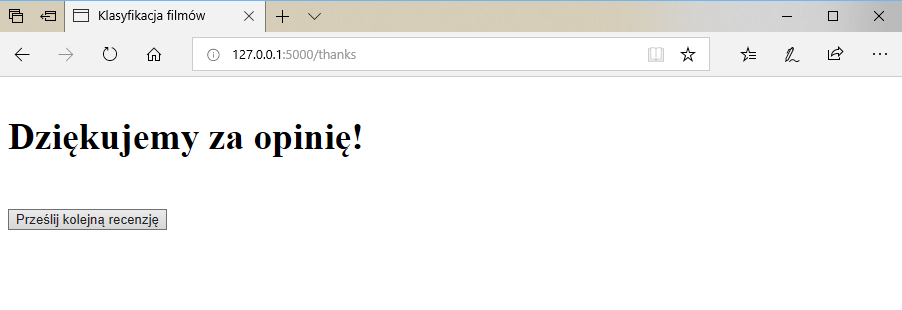

In [13]:
Image(filename='./rysunki/09_06.png', width=400) 

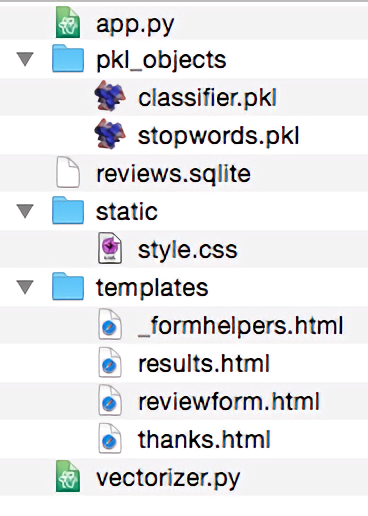

In [14]:
Image(filename='./rysunki/09_07.png', width=200) 

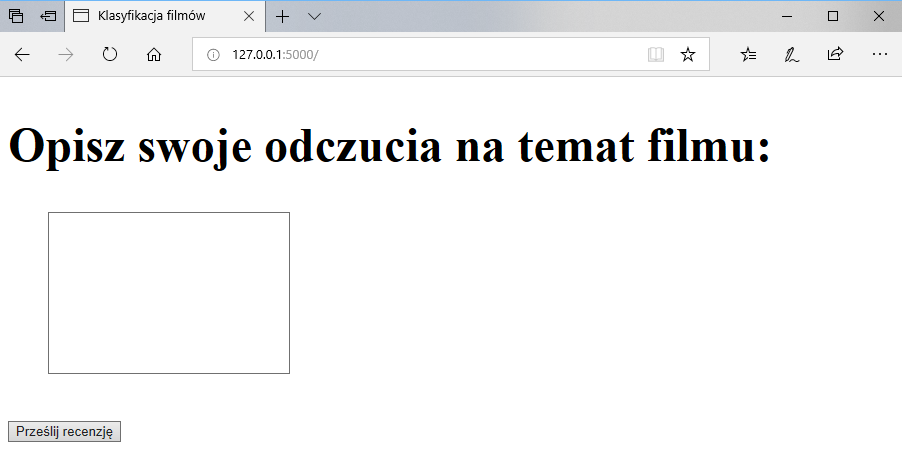

In [15]:
Image(filename='./rysunki/09_10.png', width=400) 

<br>
<br>

# Umieszczanie aplikacji sieciowej na publicznym serwerze

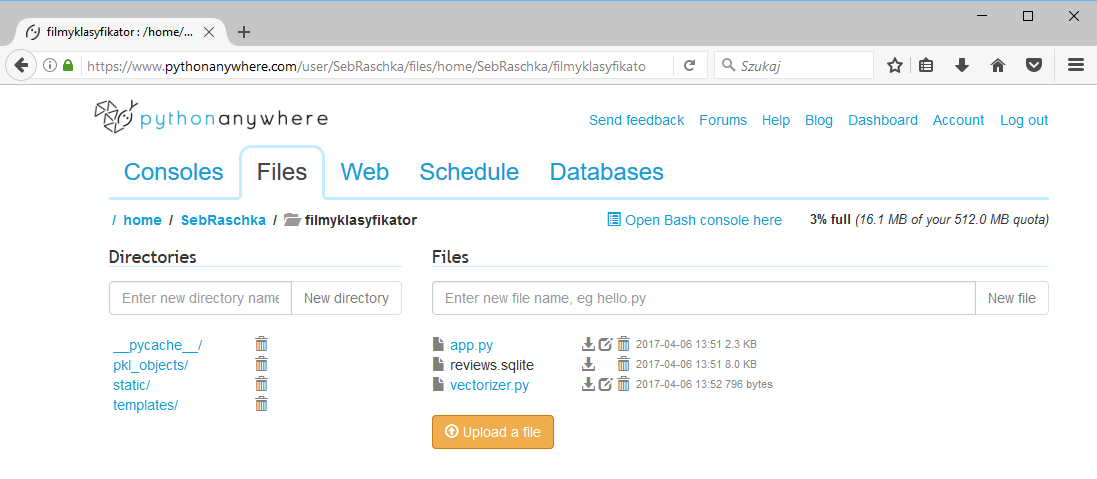

In [16]:
Image(filename='./rysunki/09_08.png', width=600) 

<br>
<br>

## Aktualizowanie klasyfikatora recenzji filmowych

Stwórzmy kopię podkatalogu klasyfikator_filmowy, na której będziemy działać (powinna już istnieć w niniejszym repozytorium; w przeciwnym wypadku stwórz kopię katalogu `klasyfikator_filmowy`).

In [39]:
import shutil

os.chdir('..')

if not os.path.exists('zaktualizowany_klasyfikator_filmowy'):
    os.mkdir('zaktualizowany_klasyfikator_filmowy')
os.chdir('zaktualizowany_klasyfikator_filmowy')

if not os.path.exists('pkl_objects'):
    os.mkdir('pkl_objects')

shutil.copyfile('../klasyfikator_filmowy/pkl_objects/classifier.pkl',
                './pkl_objects/classifier.pkl')

shutil.copyfile('../klasyfikator_filmowy/reviews.sqlite',
                './reviews.sqlite')

'./reviews.sqlite'

Definiujemy funkcję aktualizującą klasyfikator przy użyciu informacji przechowywanych w lokalnej bazie danych SQLite:

In [40]:
import pickle
import sqlite3
import numpy as np

# importuje klasę HashingVectorizer z lokalnego katalogu
from vectorizer import vect

def update_model(db_path, model, batch_size=10000):

    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute('SELECT * from Recenzja_db')
    
    results = c.fetchmany(batch_size)
    while results:
        data = np.array(results)
        X = data[:, 0]
        y = data[:, 1].astype(int)
    
        classes = np.array([0, 1])
        X_train = vect.transform(X)
        clf.partial_fit(X_train, y, classes=classes)
        results = c.fetchmany(batch_size)
    
    conn.close()
    return None

Aktualizacja modelu:

In [41]:
cur_dir = '.'

# Zastosuj poniższą ścieżkę, jeżeli zamierzasz umieścić ten
# fragment kodu w pliku app.py

# import os
# cur_dir = os.path.dirname(__file__)

clf = pickle.load(open(os.path.join(cur_dir,
                 'pkl_objects',
                 'classifier.pkl'), 'rb'))
db = os.path.join(cur_dir, 'reviews.sqlite')

update_model(db_path=db, model=clf, batch_size=10000)

# usuń komentarze z poniższych wierszy w celu aktualizowania pliku classifier.pkl

# pickle.dump(clf, open(os.path.join(cur_dir, 
#             'pkl_objects', 'classifier.pkl'), 'wb')
#             , protocol=4)

<br>
<br>

# Podsumowanie

<br>
...
<br>